# Examination of GSE69244

Tong Shu Li

In [1]:
import operator
import pandas as pd
import sys

from functools import partial
from functools import reduce

In [2]:
sys.path.append("..")

In [3]:
from src.plots import plot_drift
from src.plots import plot_p_val_heatmap

from src.stats import p_val_pairs

from src.load_gene_ont import load_go
from src.load_gene_ont import parse_go_defn

In [4]:
%matplotlib inline

---

## Read the pre-normalized drift data

In [5]:
data = pd.read_csv("../data/GSE69244/norm_avg_drift.tsv", sep = '\t')

In [6]:
data.shape

(45690, 10)

In [7]:
data.head()

,months_old,drug_given,gene_id,mgi_id,gene_count,log_count,ref_log_count,ref_sample,drift,sample_name
0,3,vehicle,0610007P14Rik,MGI:1915571,342.5,5.836272,5.720312,1,-0.034916,young
1,3,vehicle,0610009B22Rik,MGI:1913300,154.0,5.036953,4.836282,1,0.049794,young
2,3,vehicle,0610009L18Rik,MGI:1914088,23.5,3.157000,2.944439,1,0.061685,young
3,3,vehicle,0610009O20Rik,MGI:1914089,551.0,6.311735,6.214608,1,-0.053750,young
4,3,vehicle,0610010F05Rik,MGI:1918925,694.0,6.542472,6.545350,1,-0.153754,young


## Read the mouse GO annotations

In [8]:
go_defn = parse_go_defn("../data/gene_ontology/go.obo")

In [9]:
mouse_go = load_go("../data/gene_ontology/gene_association.mgi")

In [10]:
mouse_go.shape

(369000, 16)

In [11]:
mouse_go.head()

,database_id,db_obj_symbol,qualifier,go_id,db_ref,evidence,with_from,aspect,db_obj_name,db_obj_syn,db_obj_type,taxon,date,assigned_by,annot_ext,gene_prod_id
0,MGI:1918911,0610005C13Rik,NaN,GO:0003674,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,F,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20100209,MGI,NaN,NaN
1,MGI:1918911,0610005C13Rik,NaN,GO:0005575,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,C,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20100209,MGI,NaN,NaN
2,MGI:1918911,0610005C13Rik,NaN,GO:0008150,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,P,RIKEN cDNA 0610005C13 gene,NaN,gene,taxon:10090,20100209,MGI,NaN,NaN
3,MGI:1923503,0610006L08Rik,NaN,GO:0003674,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,F,RIKEN cDNA 0610006L08 gene,NaN,gene,taxon:10090,20120430,MGI,NaN,NaN
4,MGI:1923503,0610006L08Rik,NaN,GO:0005575,MGI:MGI:2156816|GO_REF:0000015,ND,NaN,C,RIKEN cDNA 0610006L08 gene,NaN,gene,taxon:10090,20120430,MGI,NaN,NaN


In [12]:
mouse_go["go_id"].nunique()

16940

In [13]:
mouse_go["database_id"].nunique()

24215

---

## Drift for all samples

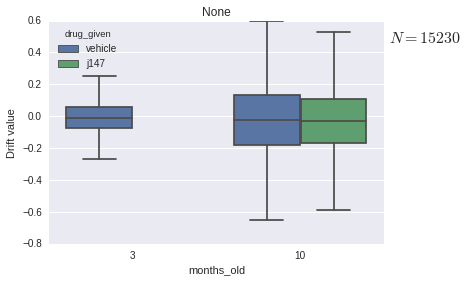

In [14]:
plot_drift(
    "box", data, "months_old", "drift", "gene_id", groupby = "drug_given"
)

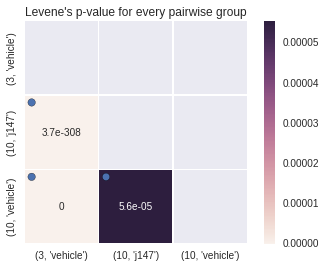

In [15]:
plot_p_val_heatmap(
    data, ["months_old", "drug_given"], "drift", circles = True
)

So of course with this many genes, the reduction in drift with J147 is significant. Can we however find GO groups which had a significant reduction in drift?

---

## Drift by GO term

In [16]:
# save the gene names for each GO term
go_groups = {
    go_term: set(df["database_id"])
    for go_term, df in mouse_go.groupby("go_id")
}

In [17]:
def filter_go(go_terms, go_groups, dataframe):
    """Filters a dataframe down to genes belonging to the listed GO terms."""
    genes = reduce(operator.or_, (go_groups[term] for term in go_terms))
    
    temp = pd.DataFrame({"mgi_id": list(genes)})
    return pd.merge(temp, dataframe, how = "inner", on = "mgi_id")

## Hypothesis testing

In [18]:
info = pd.DataFrame(
    [(go_term, len(genes)) for go_term, genes in go_groups.items()],
    columns = ["go_id", "num_genes"]
)

info = pd.merge(info, go_defn, how = "inner", on = "go_id")

In [19]:
good_genes = set(data["mgi_id"])

info["num_in_data"] = info["go_id"].map(
    lambda v: len(good_genes & go_groups[v])
)

info = info.sort_values("num_in_data", ascending = False).reset_index(drop = True)

In [20]:
info.head()

,go_id,num_genes,go_name,num_in_data
0,GO:0016020,6874,membrane,5637
1,GO:0005737,6356,cytoplasm,5543
2,GO:0005634,5702,nucleus,4839
3,GO:0005515,4437,protein binding,3846
4,GO:0003674,7989,molecular_function,3458


In [21]:
info.shape

(16940, 4)

In [22]:
info["num_genes"].describe()

count    16940.000000
mean        18.002302
std        161.927636
min          1.000000
25%          1.000000
50%          3.000000
75%          8.000000
max       7989.000000
Name: num_genes, dtype: float64

In [23]:
(info["num_in_data"] >= 10).sum()

3329

In [24]:
info = info.query("num_in_data >= 10")

## Significance checking function

In [25]:
def signif(go_term, df, go_groups, groupby, drift_col, conditions):
    """Check for significant drift.
    
    For a subset of genes specified by the GO term, calculates the
    p-values when grouped together by the groupby. Then checks that
    all p values of the condition pairs are below the significance
    threshold.
    
    Conditions = dict(key: direction)
    where key = pair of groups, direction = boolean of whether the variance
    of the left group is larger
    """
    res = filter_go([go_term], go_groups, df)
    
    p_vals = p_val_pairs(res, groupby, drift_col)
    
    threshold = 0.05
    for pair in conditions:
        assert pair in p_vals, "{} not in p-val pairs".format(pair)
        
    return all(
        p_vals[i][0] < threshold and p_vals[i][1] == direction
        for i, direction in conditions.items()
    )

## GO groups which increase in drift in vehicle

In [26]:
drift_ctrl = partial(
    signif, df = data.query("drug_given == 'vehicle'"),
    go_groups = go_groups, groupby = "months_old",
    drift_col = "drift",
    conditions = {(3, 10): False}
)

info["d_ctrl"] = info["go_id"].map(drift_ctrl)

In [27]:
info.head()

,go_id,num_genes,go_name,num_in_data,d_ctrl
0,GO:0016020,6874,membrane,5637,True
1,GO:0005737,6356,cytoplasm,5543,True
2,GO:0005634,5702,nucleus,4839,True
3,GO:0005515,4437,protein binding,3846,True
4,GO:0003674,7989,molecular_function,3458,True


In [28]:
info["d_ctrl"].value_counts()

True     1908
False    1421
Name: d_ctrl, dtype: int64

In [29]:
info.query("d_ctrl")["num_in_data"].describe()

count    1908.000000
mean       91.828616
std       320.269873
min        10.000000
25%        17.000000
50%        30.000000
75%        59.000000
max      5637.000000
Name: num_in_data, dtype: float64

## GO groups which decrease in drift when given J147

In [30]:
drift_old = partial(
    signif, df = data.query("months_old == 10"),
    go_groups = go_groups, groupby = "drug_given",
    drift_col = "drift",
    conditions = {("j147", "vehicle"): False}
)

info["reduc_j147"] = info["go_id"].map(drift_old)

In [31]:
info["reduc_j147"].value_counts()

False    3318
True       11
Name: reduc_j147, dtype: int64

In [32]:
info.query("reduc_j147")

,go_id,num_genes,go_name,num_in_data,d_ctrl,reduc_j147
0,GO:0016020,6874,membrane,5637,True,True
1,GO:0005737,6356,cytoplasm,5543,True,True
2,GO:0005634,5702,nucleus,4839,True,True
3,GO:0005515,4437,protein binding,3846,True,True
11,GO:0000166,1845,nucleotide binding,1701,True,True
99,GO:0006397,303,mRNA processing,293,True,True
132,GO:0008380,226,RNA splicing,219,True,True
1562,GO:0036464,25,cytoplasmic ribonucleoprotein granule,22,False,True
2014,GO:0043409,18,negative regulation of MAPK cascade,17,False,True
2859,GO:0048038,13,quinone binding,11,True,True


Hmm, so only one GO group with a reasonable number of genes is significantly drifting?